# Packages

In [1]:
#basic packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#data pre-processing packages
import tarfile
import urllib
from datetime import datetime
from windrose import WindroseAxes
from matplotlib.cm import ScalarMappable
from pywaffle import Waffle

#results and analysis packages
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#data-preparation packages
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from astropy.table import QTable
# import astropy.units as u

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from yellowbrick.regressor import PredictionError, ResidualsPlot

from scipy import stats

#linear models packages
from sklearn.linear_model import LinearRegression


# Script

## Errors computation

In [3]:
#defining the Root Mean Squared Error

def rmse(y_true, y_predicted):
    
    return np.sqrt(mean_squared_error(y_true, y_predicted))

In [4]:
def non_SC_error (data, power_curve):
    
    data['WS_pred']=data['WS1']
    
    data1=powercurve_computation(data, power_curve)
    
    errors_computation(data1, power_curve)
    
    
    return print('Not pursuing a SC error has been computed')

In [5]:
#errors computation

def errors_computation(data, power_curve):
    
    df=pd.DataFrame()
    df.at['RMSE (as root mean)', 'Wind']= round(rmse(data['Target'], data['WS_pred']), 3)
    df.at['MAE (in avg)', 'Wind']= round(mae(data['Target'], data['WS_pred']), 3)
    df.at['MAPE (%)', 'Wind']= round(mape(data['Target'], data['WS_pred'])*100, 3)
    
    df.at['RMSE (as root mean)', 'Power']= round(rmse(data['P'], data['P_pred']), 3)
    df.at['MAE (in avg)', 'Power']= round(mae(data['P'], data['P_pred']), 3)
    df.at['MAPE (%)', 'Power']= round(mape(data['P'], data['P_pred'])*100, 3)
    
    
    print('Wind RMSE: ', round(rmse(data['Target'], data['WS_pred']), 3), 'm/s as root mean')
    print('Wind MAE: ', round(mae(data['Target'], data['WS_pred']), 3), 'm/s in avg')
    print('Wind MAPE: ', round(mape(data['Target'], data['WS_pred'])*100, 3), '%')
    
    print('Power RMSE: ', round(rmse(data['P'], data['P_pred']), 3), 'kW as root mean')
    print('Power MAE: ', round(mae(data['P'], data['P_pred']), 3), 'kW in avg')
    print('Power MAPE: ', round(mape(data['P'], data['P_pred'])*100, 3), '%')
    
    AEP_table=AEP_computation(data, power_curve)
    
    return df, AEP_table

In [6]:
def error_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot([-1,17.5],[-1,17.5], 'green', linewidth=4, alpha=.12)
    plt.plot(data['WS_pred'], data['Target'], marker='o', ls='', label='Regression', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='y predicted', ylabel='y actual');
    ax.set_title(title)
    ax.set_ylim(ymin=4, ymax=17.5)
    ax.set_xlim(xmin=4, xmax=17.5)
    
    return print('Error plot performed')

In [7]:
def AEP_computation(data, power_curve1):
    
    #binning the WS_Pred unit and 0.5-centered
    data['WS_pred_bin']=pd.cut(data['WS_pred'],
                                       bins=list(np.arange(-0.25,28.0,0.5)),
                                                 labels=list(np.arange(0.0,28.0,0.5)))
#     #binning the WS_Pred at the beginning
#     data['WS_pred_bin']=pd.cut(data['WS_pred'],
#                                        bins=list(np.arange(0.0,28.5,0.5)),
#                                                  labels=list(np.arange(0.0,28.0,0.5)))

    
#     #binning the WS_Pred all at the end
#     data['WS_pred_bin']=pd.cut(data['WS_pred'],
#                                        bins=list(np.arange(-0.5,28.0,0.5)),
#                                                  labels=list(np.arange(0.0,28.0,0.5)))
    

        
    #creating the AEP (Annual Energy Production table)
    power_curve=power_curve1.copy()
    power_curve.set_index('Wind Speed [m/s]', inplace=True)
        
    AEP_table=pd.DataFrame()
    
    AEP_table['WS']=power_curve.index
    AEP_table.set_index('WS', inplace=True)
    AEP_table['WPC']=power_curve['Warranted Power Curve [kW]']   
    AEP_table['MPC_SC']=data.groupby('WS_pred_bin', as_index=True)['P'].mean()
#     WS1=AEP_table.index
#     AEP_table.reset_index()
#     AEP_table.insert(0, 'WS',WS1)

    #puedo rellenar los NaN de MPC_SC copiando lo que tendría que ser: WPC
    
#     for i in AEP_table.index:
#         if math.isnan(AEP_table.at[i, 'MPC_SC']):
#             AEP_table.at[i, 'MPC_SC']=AEP_table.at[i, 'WPC']
    
    AEP_table['WSAD']=power_curve['Wind Speed Distribution [Hr/Year]']
    
    #o igual aquí tendría que cortar la tabla para NaN values
    
    AEP_table=AEP_table.dropna()
    
    AEP_table['WAEP']=AEP_table['WPC']*AEP_table['WSAD']
    AEP_table['MAEP_SC']=AEP_table['MPC_SC']*AEP_table['WSAD']
    
    
    
    #computing the metrics for later printing
    AEP_table2=pd.DataFrame(columns=AEP_table.columns)
    
    for i in AEP_table.index:
        if i>=3 and i<=15.5:
            AEP_table2.loc[i]=AEP_table.loc[i]
#             AEP_table2=pd.concat([AEP_table.loc[i], AEP_table2], ignore_index=True)
            
    
#     AEP_table2 = AEP_table[AEP_table.index.between(3.0,15.5)]
    
#     AEP_table2=AEP_table.dropna()
    
    #o igual aquí tendría que cortar la tabla para NaN values
    
    MAEP_SC=AEP_table2['MAEP_SC'].sum()
    WAEP=AEP_table2['WAEP'].sum()
    AEP_perc=(MAEP_SC/WAEP)*100
    AEP_diff=(MAEP_SC-WAEP)/1000
    
    
    
    #building table to print
    
    WS= AEP_table2.index
    WPC=AEP_table2['WPC']
    MPC=round(AEP_table2['MPC_SC'],0)
    WSAD=AEP_table2['WSAD']
    WAEP=round(AEP_table2['WAEP']/1000, 3)
    MAEP=round(AEP_table2['MAEP_SC']/1000, 3)
    
    AEP_table1=pd.DataFrame()
    AEP_table1['WS']=WS
    AEP_table1.set_index('WS', inplace=True)
    AEP_table1['WPC (kW)']=WPC
    AEP_table1['MPC_SC (kW)']=MPC
    AEP_table1['WSAD (h/year)']=WSAD
    AEP_table1['WAEP (MWh)']=WAEP
    AEP_table1['MAEP_SC (MWh)']=MAEP
    
    
    
    #printing the results

    print('')
    print('The computed AEP_table is: ')
    print(AEP_table1)
#     AEP_table_draw(AEP_table)
    print('')
    print('The AEP% of the Site Calibration is: ', round(AEP_perc, 3), '%')
    print('')
    print('The AEP difference of the Site Calibration is: ', round(AEP_diff, 3), 'MWh')
    print('')
    AEP_plot(data, AEP_table)                                
    
    
    return AEP_table2

In [8]:
list(np.arange(-0.5,28.0,0.5))

[-0.5,
 0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 16.5,
 17.0,
 17.5,
 18.0,
 18.5,
 19.0,
 19.5,
 20.0,
 20.5,
 21.0,
 21.5,
 22.0,
 22.5,
 23.0,
 23.5,
 24.0,
 24.5,
 25.0,
 25.5,
 26.0,
 26.5,
 27.0,
 27.5]

In [9]:
list(np.arange(0.0,28.0,0.5))

[0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 16.5,
 17.0,
 17.5,
 18.0,
 18.5,
 19.0,
 19.5,
 20.0,
 20.5,
 21.0,
 21.5,
 22.0,
 22.5,
 23.0,
 23.5,
 24.0,
 24.5,
 25.0,
 25.5,
 26.0,
 26.5,
 27.0,
 27.5]

In [10]:
def AEP_plot(data, AEP_table):
    
    #data is expected to contain: Target, WS_pred, P, P_pred
    #AEP_table is expected to contain: WS, WPC, MPC-SC

    #plotting the Power curves
    plt.figure(figsize=(10,6))
    plt.plot(data['WS_pred'], data['P'], marker='o', ls='', label='measured scatter', markersize=5, alpha=.1)
    plt.plot(AEP_table.index, AEP_table['WPC'], marker='o', color='black', linewidth=0.5, label='WPC', markersize=5)
    plt.plot(AEP_table.index, AEP_table['MPC_SC'], marker='o', color='red', linewidth=0.5, label='SC-MPC', markersize=5)


    plt.legend(fontsize=12)

    ax=plt.gca()
    ax.set(ylabel='Power interpolated with WPC and Target WS (kW)', xlabel='Predicted Wind Speed (m/s)');
    ax.set_title('Site Calibration Power Curve')
    ax.set_xlim(xmin=0, xmax=20)
#     ax.set_xlim(xmin=0, xmax=27.5)
    
    return print('Error plot performed')

In [11]:
def AEP_table_draw(AEP_table):
    
    #AEP_table is expected to contain: WPC, MPC_SC, WPC, WSAD, WAEP, MAEP_SC
    
    WS= AEP_table.index
    WPC=AEP_table['WPC']
    MPC=round(AEP_table['MPC_SC'],0)
    WSAD=AEP_table['WSAD']
    WAEP=round(AEP_table['WAEP']/1000000, 3)
    MAEP=round(AEP_table['MAEP_SC']/1000000, 3)
    
    row_headers=list(AEP_table.index)

    column_headers=('Wind speed bin (m/s)', 'WPC (kW)', 'MPC_SC (kW)',
                    'Annual Wind Distribution (h/year)', 'WAEP (GWh)', 'MAEP (GWh)')

    rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))

    l_2d=[list(WS), list(WPC), list(MPC), list(WSAD), list(WAEP), list(MAEP)]

    cell_text=np.array(l_2d).T

    fig, ax = plt.subplots(figsize=(12,5)) 
    ax.set_axis_off()

    the_table=ax.table(cellText=cell_text,
                       rowLabels=row_headers,
                       rowColours=rcolors,
                       rowLoc='right',
                       colColours=ccolors,
                       colLabels=column_headers,
                       cellLoc ='center',
                       loc='upper center',
                       colWidths = [0.1] * 5)

    ax.set_title('Annual Energy Production for Site Calibration PC', 
                 fontweight ="bold", fontsize=14) 

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    
    return ('AEP table printed')



# row_headers=index
#     column_headers=('Overall', 'Stratified', 'Random', 'Rand. %error', 'Strat. %error')
    
#     rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
#     ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
    
#     l_2d=[list(Overall), list(Stratified), list(Random), list(Rand_error), list(Strat_error)]
     
#     cell_text=np.array(l_2d).T
    
#     fig, ax = plt.subplots(figsize=(12,5)) 
#     ax.set_axis_off()
    
#     the_table=ax.table(cellText=cell_text,
#                       rowLabels=row_headers,
#                       rowColours=rcolors,
#                       rowLoc='right',
#                       colColours=ccolors,
#                       colLabels=column_headers,
#                       cellLoc ='center',
#                       loc='upper center',
#                       colWidths = [0.1] * 5)

## Data reference

In [12]:
def WDbins_uncomplete(data):
    
    data1=data.copy()
    bins_2drop=[]
    
    #above and below 8 m/s para 36 heartbeats
    
    #classification
    for i in data.index:
        if data.at[i, 'WS1']>=8:
            data.at[i, '8 m/s']='Above'
        else:
            data.at[i, '8 m/s']='Below'
    
    columns=data[['WD_bin', '8 m/s']]
    df=columns.copy()
    
    binsx=df.groupby(['WD_bin']).count()
    bins2=pd.DataFrame(binsx)
    
    #filing the list bins_2drop
    for b in bins2.index:
        if bins2.at[b, '8 m/s']<36:
            bins_2drop.append(b)
            
    ########        
            
        
            
    #total para 144 heartbeats
    bins=data['WD_bin'].value_counts()
    bins1=pd.DataFrame(bins)
    
    
    for b in bins1.index:
        if bins1.at[b, 'WD_bin']<144:
            bins_2drop.append(b)
            
    #removing duplicates
    bins_2drop=list(dict.fromkeys(bins_2drop))
            
    print('Bins to drop: ', bins_2drop)
    
    
    #####dropping the values
    
    for i in data.index:
        if data.at[i, 'WD_bin'] in bins_2drop:
            data1=data1.drop(index=i)
    
    if '8 m/s' in data1.keys():
        data1=data1.drop(columns=['8 m/s'])
    data2=data1.reset_index(drop=True)
#     data1=data1.drop(columns=index)
            
    print('Data removed for IEC computation: ', round((len(data)-len(data1))/len(data)*100, 2), '%')
    
    return data2

In [13]:
def power_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot(data['Target'], data['P'], marker='o', ls='', label='Power curve', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='Target wind speed (m/s)', ylabel='Power computed (kW)');
    ax.set_title(title)
    
    return print('Error plot performed')

In [14]:
#predicted wind speed at the hub height regarding regular SC

def FCF_application(data,matrix):
    
    data1=data.copy()
    data2=data.copy()
    
    
#     matrix=FCF_computation(data) # in this case, the FCFs will be computed for the train set
                                    #but will be applied to the test set
    
    
    for i in data1.index:
        for b in matrix.index:
            if data1.at[i, 'WD_bin']== b:
                data2.at[i, 'WS_pred']=data1.at[i, 'WS1']*matrix.at[b, 'ratio']
                
            
    return data2

In [15]:
def FCF_computation(data):
    
    if 'WD_bin' not in data.keys():
        print('Wind direction bin clustering missing')
        
    FCF_table=data.groupby('WD_bin', as_index=False)['ratio'].mean()
    FCF_table.set_index('WD_bin', inplace=True)
    
    FCF_table=FCF_table.dropna()
    
    print('The computed FCF_table is: ')
    print(FCF_table)
    
    
    return FCF_table

In [16]:
#reference data

def apply_reference(data, power_curve):
    
    #this function creates a reference dataFrame by using the IEC metholodogy
    #this function requires the WD_bins clustering
    #this function uses the following functions:
    # FCF_computation
    # FCF_application
    # 


    if 'WD_bin' not in data.keys():
        print('Wind direction bin clustering missing')
        

    #applying the FCFs computed internally on FCF_application :
    if 'WS_pred' not in data.keys():
        data=FCF_application(data)
    
    if 'P_pred' not in data.keys():
        print('power_computation missing')

    print('IEC method errors:')
    df,AEP_table=errors_computation(data, power_curve)
    
    error_plot(data, 'IEC method regression with computed FCFs')

    
    return data,AEP_table

In [17]:
def powercurve_computation(data, power_curve):
    
    from scipy import interpolate
    
    #this function computes the power at a observation given the information at a observation:
    # the WS (in m/s) at the wind turbine location and at the hub height (Target)
    # the power curve of the wind turbine in an xslx
    
    if 'Wind Speed [m/s]' in power_curve.keys():
        x=power_curve['Wind Speed [m/s]']
    else:
        x=power_curve.index
    y=power_curve['Warranted Power Curve [kW]']
    x_new=data['Target']
    
    f = interpolate.interp1d(x, y)
    #, kind='linear'
    data['P']=f(x_new)
    
    if 'WS_pred' in data.keys():
        x_new2=data['WS_pred']
        data['P_pred']=f(x_new2)
    
    print('power curve computation performed')
    
    return data

In [18]:
def plot_FCF (data, FCF_table1, cluster):
    
    FCF_table=FCF_table1.copy()
    
    WD_0in10=pd.DataFrame()
    WD_0in10['WD_bin']=list(range(1,37,1))
    WD_0in10.set_index('WD_bin', inplace=True)
    WD_0in10['WD']=list(range(5,360,10))
    
    
    WD_0in5=pd.DataFrame()
    WD_0in5['WD_bin']=list(range(1,73,1))
    WD_0in5.set_index('WD_bin', inplace=True)
    WD_0in5['WD']=list(np.arange(2.5,360,5))
    
    
    WD_5in10=pd.DataFrame()
    WD_5in10['WD_bin']=list(range(1,37,1))
    WD_5in10.set_index('WD_bin', inplace=True)
    WD_5in10['WD']=list(range(0,360,10))
    
    
    if cluster=='WD_0in10':
        FCF_table['WD']=WD_0in10['WD']
        FCF_table.set_index('WD', inplace=True)
    elif cluster=='WD_0in5':
        FCF_table['WD']=WD_0in5['WD']
        FCF_table.set_index('WD', inplace=True)
    elif cluster=='WD_5in10':
        FCF_table['WD']=WD_5in10['WD']
        FCF_table.set_index('WD', inplace=True)
        
        
    
    #plotting the FCFs
    plt.figure(figsize=(9,5))
    plt.plot(data['WD1'], data['ratio'], marker='o', ls='', label='ratio scatter', markersize=5, alpha=.1)
    plt.plot(FCF_table.index, FCF_table, marker='o', color='red', linewidth=0.5, label='FCF', markersize=5)


    plt.legend(fontsize=12)

    ax=plt.gca()
    ax.set(ylabel='WS ratio (Target/WS1)', xlabel='Wind direction (°)');
    ax.set_title('Flow Correction Factors')
#     ax.set_ylim(ymin=0, ymax=20)
        
        
    
    print('FCF plot performed')
    
    return FCF_table
    

## Data preparation

### Data uploading

In [19]:
def uploading_csv(file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function uploads and formats csv/txt/xlsx datasets into DataFrame
    
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data1 = pd.read_csv(data_path)

    
    # We will save the WD_bin as the index
    
    return data1

In [20]:
#this function saves a data csv

def save (data, file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be saved in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function saves a csv/txt/xlsx into Irma's folder
    #the saved file will keep the columns names but not the index
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data.to_csv (data_path, index = False, header=True)
    
    
    return print('file', data_file, 'saved in', data_folder, 'folder')

### Train_test_split 

In [21]:
# to randomly split the dataset use:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [22]:
def stratified_split (data):
    
    
    #Stratified train_test_split in function of the target
    
    s=data['WS1']
    
    data_train_strat, data_test_strat = train_test_split(data, test_size=0.3, stratify=s, random_state=42)
     

    return data_train_strat, data_test_strat

In [23]:
def test_split (data1):
    
    data=data1.copy()
    
    #binning (clustering) the data by wind speed bins
    
#     data['wind speed bins']= pd.cut(data['Target'], 
#                                     bins=[3, 6, 8, 10, 12, 14, 21],
#                                     labels=['3 to 6', '6 to 8', '8 to 10', 
#                                             '10 to 12', '12 to 14', '14 to 21'])
    
    data['wind speed bins']= pd.cut(data['Target'], 
                                    bins=[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21],
                                    labels=['4 to 5', '5 to 6','6 to 7', '7 to 8','8 to 9', '9 to 10',
                                            '10 to 11', '11 to 12', '12 to 13', '13 to 14', '14 to 15','15 to 16'])
    
    #regular/random train_test_split
    
    train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)
    
    
    plt.figure(figsize=(8,6))
    sns.histplot(data['Target'], bins=15)
    
    ax=plt.gca()
    ax.set(xlabel='Target wind speed (m/s)');
    ax.set_title('Target Stratification')
    ax.set_xticks(np.arange(3,17,1))
    plt.show()
    
    
    #Stratified train_test_split in function of wind speed
    
    split=StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    
    for train_index, test_index in split.split(data, data['wind speed bins']):
        strat_train_set=data.loc[train_index]
        strat_test_set=data.loc[test_index]
        
    index= ['4 to 5', '5 to 6','6 to 7', '7 to 8','8 o 9', '9 to 10', 
            '10 to 11', '11 to 12', '12 to 13', '13 to 14','14 to 15','15 to 16']
    Overall= round(data['wind speed bins'].value_counts()/len(data),5)
    Stratified= round(strat_test_set['wind speed bins'].value_counts()/len(strat_test_set),5)
    Random= round(test_set['wind speed bins'].value_counts()/len(test_set), 5)
    Rand_error= round((Random-Overall)/Random*100,5)
    Strat_error= round((Stratified-Overall)/Stratified*100,5)
    
    #plotting the table of the comparison Random vs. Stratified
    
#     t = pd.DataFrame()
#     t['wind speed bin']=index
#     t['Overall']= Overall
#     t['Stratified']=Stratified
#     t['Random']=Random
#     t['Rand. %error']=Rand_error
#     t['Strat. %error']=Strat_error
#     t.set_index('wind speed bin', inplace=True)
    
#     print(t)
    
    row_headers=index
    column_headers=('Overall', 'Stratified', 'Random', 'Rand. %error', 'Strat. %error')
    
    rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
    
    l_2d=[list(Overall), list(Stratified), list(Random), list(Rand_error), list(Strat_error)]
     
    cell_text=np.array(l_2d).T
    
    fig, ax = plt.subplots(figsize=(12,5)) 
    ax.set_axis_off()
    
    the_table=ax.table(cellText=cell_text,
                      rowLabels=row_headers,
                      rowColours=rcolors,
                      rowLoc='right',
                      colColours=ccolors,
                      colLabels=column_headers,
                      cellLoc ='center',
                      loc='upper center',
                      colWidths = [0.1] * 5)
    
    ax.set_title('Random vs. Stratified by wind speed bin train_test_split', 
                 fontweight ="bold", fontsize=14) 
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    
    train_set=train_set.drop(columns='wind speed bins')
    test_set=test_set.drop(columns='wind speed bins')
    strat_train_set=strat_train_set.drop(columns='wind speed bins')
    strat_test_set=strat_test_set.drop(columns='wind speed bins')
     

    return strat_train_set, strat_test_set


### Get x,y

In [24]:
## a function just to get X and y

def get_xy(data):
    
    y=data['Target']
    
    X=data.drop(columns=['Target'])
    
    return X,y

### Feature Scaling

In [25]:
#%%% Feature scaling

def data_scaling(X_train, X_test):

    # Instantiate a Scaler--> NORMALIZATION
    scaler_norm = MinMaxScaler()

    # Get scaling parameters with the train sample exclusively,
    #using the Scaler.fit() function
    scaler_norm.fit(X_train)

    # Scale data using Scaler.transform()
    scaledX_train = pd.DataFrame(scaler_norm.transform(X_train),
                                columns= X_train.columns)
    
    scaledX_test = pd.DataFrame(scaler_norm.transform(X_test),
                               columns= X_test.columns)

    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,7), sharey=True)
    fig.tight_layout(pad=2.0)
    sns.set_theme(style="whitegrid")

    sns.boxplot(ax=ax1, y="variable", x="value", data=pd.melt(scaledX_train), 
                hue=None, orient="h", palette="Set2")
    ax1.set_xlabel('Feature scaling')
    ax1.set_ylabel('features')
    ax1.set_title('train scaled X data')
    
    sns.boxplot(ax=ax2, y="variable", x="value", data=pd.melt(scaledX_test), 
                hue=None, orient="h", palette="Set2")
    ax2.set_xlabel('Feature scaling')
    ax2.set_ylabel('features')
    ax2.set_title('test scaled X data')

    
    return scaledX_train, scaledX_test

## Data linearity

### Ass. 1- Linear relationship

In [26]:
def R2_table (X,y):
    
    def r2 (x,y):

        r2, p = stats.pearsonr(x, y)

        return r2

    R2_data = pd.DataFrame()

    for i in X.keys():
        R2_data.at[i,'R2']=r2(X[i], y)


    corrmat=R2_data
    plt.subplots(figsize=(3,8))
    sns.heatmap(corrmat, annot=True, annot_kws={'size':15})
    plt.title('Heatmap')
    plt.show()

    
    return print('R2 table performed')

In [27]:
def data_linearity1 (X,y):
    
    #Assumption 1- Linear relationship
    #(between target and input features)
    #checking: scatter plot target vs. each feature (+regres. line +R^2)
    #validation: 1) qualitative: there is a linear trend
    #            2) quantitative: high R^2
    

    
    def r2 (x,y):

        r2, p = stats.pearsonr(x, y)
    
        return r2
    
    fig, ax = plt.subplots(5,2, figsize=(12, 15))
    fig.suptitle('Linearity assumption 1- Linear relationship')
    fig.tight_layout(pad=2.0)

    x=X['WS1']
    sns.regplot(x=x,y=y, ax=ax[0][0], order=2, line_kws={'color': 'cyan'}, scatter_kws={'alpha':0.1})
    ax[0][0].set_ylabel('Target (m/s)')
    ax[0][0].set_xlabel('Wind Speed')
    
    txt = "R2= {value:.3f}"
    ax[0][0].text(0.5,0.5,txt.format(value=r2(x,y)),horizontalalignment='center',
     verticalalignment='center', transform = ax[0][0].transAxes, color='black')
    
    x=X['WSVer']
    sns.regplot(x=x,y=y, ax=ax[0][1], order=2, line_kws={'color': 'cyan'}, scatter_kws={'alpha':0.1})
    ax[0][1].set_ylabel('Target (m/s)')
    ax[0][1].set_xlabel('Vertical Wind Speed')
    
    txt = "R2= {value:.3f}"
    ax[0][1].text(0.5,0.5,txt.format(value=r2(x,y)),horizontalalignment='center',
     verticalalignment='center', transform = ax[0][1].transAxes, color='black')
    
    ########


    x=X['T1']
    sns.regplot(x=x,y=y, ax=ax[1][0],order=1, line_kws={'color': 'cyan'}, scatter_kws={'alpha':0.1})
    ax[1][0].set_ylabel('Target (m/s)')
    ax[1][0].set_xlabel('Temperature')
    
    txt = "R2= {value:.3f}"
    ax[1][0].text(0.5,0.5,txt.format(value=r2(x,y)),horizontalalignment='center',
     verticalalignment='center', transform = ax[1][0].transAxes, color='black')

    
    x=X['PR1']
    sns.regplot(x=x,y=y, ax=ax[1][1],order=2, line_kws={'color': 'cyan'}, scatter_kws={'alpha':0.1})
    ax[1][1].set_ylabel('Target (m/s)')
    ax[1][1].set_xlabel('Pressure')

    
    txt = "R2= {value:.3f}"
    ax[1][1].text(0.5,0.5,txt.format(value=r2(x,y)),horizontalalignment='center',
     verticalalignment='center', transform = ax[1][1].transAxes, color='black')
    
    
    ###########################

    x=X['RH1']
    sns.regplot(x=x,y=y, ax=ax[2][0],order=1, line_kws={'color': 'cyan'}, scatter_kws={'alpha':0.1})
    ax[2][0].set_ylabel('Target (m/s)')
    ax[2][0].set_xlabel('Relative Humidity')
    
    txt = "R2= {value:.3f}"
    ax[2][0].text(0.5,0.5,txt.format(value=r2(x,y)),horizontalalignment='center',
     verticalalignment='center', transform = ax[2][0].transAxes, color='black')

    
    x=X['WDVer']
    sns.regplot(x=x,y=y, ax=ax[2][1],order=2, line_kws={'color': 'cyan'}, scatter_kws={'alpha':0.1})
    ax[2][1].set_ylabel('Target (m/s)')
    ax[2][1].set_xlabel('Vertical Wind direction')

    
    txt = "R2= {value:.3f}"
    ax[2][1].text(0.5,0.5,txt.format(value=r2(x,y)),horizontalalignment='center',
     verticalalignment='center', transform = ax[2][1].transAxes, color='black')
    
    
    ###########################

    x=X['WSH']
    sns.regplot(x=x,y=y, ax=ax[3][0],order=1, line_kws={'color': 'cyan'}, scatter_kws={'alpha':0.1})
    ax[3][0].set_ylabel('Target (m/s)')
    ax[3][0].set_xlabel('Wind shear')
    
    txt = "R2= {value:.3f}"
    ax[3][0].text(0.5,0.5,txt.format(value=r2(x,y)),horizontalalignment='center',
     verticalalignment='center', transform = ax[3][0].transAxes, color='black')

    
    x=X['TI']
    sns.regplot(x=x,y=y, ax=ax[3][1],order=2, line_kws={'color': 'cyan'}, scatter_kws={'alpha':0.1})
    ax[3][1].set_ylabel('Target (m/s)')
    ax[3][1].set_xlabel('Turbulence Intensity')

    txt = "R2= {value:.3f}"
    ax[3][1].text(0.5,0.5,txt.format(value=r2(x,y)),horizontalalignment='center',
     verticalalignment='center', transform = ax[3][1].transAxes, color='black')
    
        ###########################

    x=X['WD1']
    sns.regplot(x=x,y=y, ax=ax[4][0],order=1, line_kws={'color': 'cyan'}, scatter_kws={'alpha':0.1})
    ax[4][0].set_ylabel('Target (m/s)')
    ax[4][0].set_xlabel('Wind Direction')
    
    txt = "R2= {value:.3f}"
    ax[4][0].text(0.5,0.5,txt.format(value=r2(x,y)),horizontalalignment='center',
     verticalalignment='center', transform = ax[4][0].transAxes, color='black')

    
    x=X['WVeer']
    sns.regplot(x=x,y=y, ax=ax[4][1],order=2, line_kws={'color': 'cyan'}, scatter_kws={'alpha':0.1})
    ax[4][1].set_ylabel('Target (m/s)')
    ax[4][1].set_xlabel('Wind Veer')

    txt = "R2= {value:.3f}"
    ax[4][1].text(0.5,0.5,txt.format(value=r2(x,y)),horizontalalignment='center',
     verticalalignment='center', transform = ax[4][1].transAxes, color='black')
    
    
    
    
    return print('Assumption 1- Linear relationship')

### Ass. 2- Multivariate normality

In [28]:
def data_linearity2_o (data):
    
    #Assumption 2- Multivariate normality
    #(for each feature-> compare their actual distribution with
    #their theoretical normal distribution)
    #checking: 1) histogram for each input feature
    #          2) Q-Q Plot
    #validation: 1) qualitative for each plot check the similarities to
    #               normal distribution
    #            2) quantitative: scipy.stats.kstest [p-value<=0.05]
    #            or 
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    
    def pvalue (x):

        
        ntest=stats.normaltest(x)
        ktest = stats.kstest(x, 'norm', N=20)
        statistics=ntest[0]
        pvalue=ntest[1]
    
        return pvalue
    
    
    fig, ax = plt.subplots(10,2, figsize=(9, 25))
    fig.suptitle('Linearity assumption 2- Multivariate normality')
    fig.tight_layout(pad=2.0)
    
    #wind speed
    x=data['WS1']
    sns.distplot(x, ax=ax[0][0], bins=20)
    ax[0][0].set_title('Histogram')
    ax[0][0].set_ylabel('WS1',fontsize=12)
    ax[0][0].set_xlabel('')

    
    sm.graphics.qqplot(x, ax=ax[0][1], dist=stats.norm, line='r')
    ax[0][1].set_title('Q-Q plot')
    txt = "p-value= {value:.3f}"
    ax[0][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
                  verticalalignment='center', transform = ax[0][1].transAxes, color='black')

    
    
    #WSVer
    x=data['WSVer']
    sns.distplot(x, ax=ax[1][0], bins=20)
    ax[1][0].set_ylabel('WSVer',fontsize=12)
    ax[1][0].set_xlabel('')
    
    sm.graphics.qqplot(x, ax=ax[1][1], dist=stats.norm, line='r')
    txt = "p-value= {value:.3f}"
    ax[1][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
                  verticalalignment='center', transform = ax[1][1].transAxes, color='black')
    
    #T1
    x=data['T1']
    sns.distplot(x, ax=ax[2][0], bins=20)
    ax[2][0].set_ylabel('T1',fontsize=12)
    ax[2][0].set_xlabel('')
    
    sm.graphics.qqplot(x, ax=ax[2][1], dist=stats.norm, line='r')
    txt = "p-value= {value:.3f}"
    ax[2][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
                  verticalalignment='center', transform = ax[2][1].transAxes, color='black')
    
    #PR1
    x=data['PR1']
    sns.distplot(x, ax=ax[3][0], bins=20)
    ax[3][0].set_ylabel('PR1',fontsize=12)
    ax[3][0].set_xlabel('')
    
    sm.graphics.qqplot(x, ax=ax[3][1], dist=stats.norm, line='r')
    txt = "p-value= {value:.3f}"
    ax[3][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
                  verticalalignment='center', transform = ax[3][1].transAxes, color='black')
    
    #WD1
    x=data['WD1']
    sns.distplot(x, ax=ax[4][0], bins=20)
    ax[4][0].set_ylabel('WD1',fontsize=12)
    ax[4][0].set_xlabel('')
    
    sm.graphics.qqplot(x, ax=ax[4][1], dist=stats.norm, line='r')
    txt = "p-value= {value:.3f}"
    ax[4][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
                  verticalalignment='center', transform = ax[4][1].transAxes, color='black')
    
    #WDVer
    x=data['WDVer']
    sns.distplot(x, ax=ax[5][0], bins=20)
    ax[5][0].set_ylabel('WDVer',fontsize=12)
    ax[5][0].set_xlabel('')
    
    sm.graphics.qqplot(x, ax=ax[5][1], dist=stats.norm, line='r')
    txt = "p-value= {value:.3f}"
    ax[5][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
                  verticalalignment='center', transform = ax[5][1].transAxes, color='black')
    
    #RH1
    x=data['RH1']
    sns.distplot(x, ax=ax[6][0], bins=20)
    ax[6][0].set_ylabel('RH1',fontsize=12)
    ax[6][0].set_xlabel('')
    
    sm.graphics.qqplot(x, ax=ax[6][1], dist=stats.norm, line='r')
    txt = "p-value= {value:.3f}"
    ax[6][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
                  verticalalignment='center', transform = ax[6][1].transAxes, color='black')
    
    #WVeer
    x=data['WVeer']
    sns.distplot(x, ax=ax[7][0], bins=20)
    ax[7][0].set_ylabel('WVeer',fontsize=12)
    ax[7][0].set_xlabel('')
    
    sm.graphics.qqplot(x, ax=ax[7][1], dist=stats.norm, line='r')
    txt = "p-value= {value:.3f}"
    ax[7][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
                  verticalalignment='center', transform = ax[7][1].transAxes, color='black')
    
    #WSH
    x=data['WSH']
    sns.distplot(x, ax=ax[8][0], bins=20)
    ax[8][0].set_ylabel('WSH',fontsize=12)
    ax[8][0].set_xlabel('')
    
    sm.graphics.qqplot(x, ax=ax[8][1], dist=stats.norm, line='r')
    txt = "p-value= {value:.3f}"
    ax[8][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
                  verticalalignment='center', transform = ax[8][1].transAxes, color='black')
    
    #TI
    x=data['TI']
    sns.distplot(x, ax=ax[9][0], bins=20)
    ax[9][0].set_ylabel('TI',fontsize=12)
    ax[9][0].set_xlabel('')
    
    sm.graphics.qqplot(x, ax=ax[9][1], dist=stats.norm, line='r')
    txt = "p-value= {value:.3f}"
    ax[9][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
                  verticalalignment='center', transform = ax[9][1].transAxes, color='black')
    
    return print('Assumption 2- Multivariate normality')

In [29]:
def data_linearity2 (X):
    
    #Assumption 2- Multivariate normality
    #(for each feature-> compare their actual distribution with
    #their theoretical normal distribution)
    #checking: 1) histogram for each input feature
    #          2) Q-Q Plot
    #validation: 1) qualitative for each plot check the similarities to
    #               normal distribution
    #            2) quantitative: scipy.stats.kstest [p-value<=0.05]
    #            or 
    
    def pvalue (x):

        ktest = stats.kstest(x, 'norm', N=20)
        statistics=ktest[0]
        pvalue=ktest[1]
    
        return pvalue
    
    
    fig, ax = plt.subplots(4,2, figsize=(12, 15))
    fig.suptitle('Linearity assumption 2- Multivariate normality', fontsize=23)
    fig.tight_layout(pad=3.0)
    

    
    #################################
    x=X['WS1']
    sm.graphics.qqplot(x, ax=ax[0][0], dist=stats.norm, line='r')
    ax[0][0].set_title('Q-Q plot for WS1')
    txt = "p-value= {value:.3f}"
    ax[0][0].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
     verticalalignment='center', transform = ax[0][0].transAxes, color='black')

    x=X['WDVer']
    sm.graphics.qqplot(x, ax=ax[0][1], dist=stats.norm, line='r')
    ax[0][1].set_title('Q-Q plot for WSVer')
    txt = "p-value= {value:.3f}"
    ax[0][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
     verticalalignment='center', transform = ax[0][1].transAxes, color='black')
    
    
        #################################
    x=X['T1']
    sm.graphics.qqplot(x, ax=ax[1][0], dist=stats.norm, line='r')
    ax[1][0].set_title('Q-Q plot for T1')
    txt = "p-value= {value:.3f}"
    ax[1][0].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
     verticalalignment='center', transform = ax[1][0].transAxes, color='black')

    x=X['PR1']
    sm.graphics.qqplot(x, ax=ax[1][1], dist=stats.norm, line='r')
    ax[1][1].set_title('Q-Q plot for PR1')
    txt = "p-value= {value:.3f}"
    ax[1][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
     verticalalignment='center', transform = ax[1][1].transAxes, color='black')
    
    
            #################################
    x=X['RH1']
    sm.graphics.qqplot(x, ax=ax[2][0], dist=stats.norm, line='r')
    ax[2][0].set_title('Q-Q plot for RH1')
    txt = "p-value= {value:.3f}"
    ax[2][0].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
     verticalalignment='center', transform = ax[2][0].transAxes, color='black')

    x=X['Ri']
    sm.graphics.qqplot(x, ax=ax[2][1], dist=stats.norm, line='r')
    ax[2][1].set_title('Q-Q plot for Ri')
    txt = "p-value= {value:.3f}"
    ax[2][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
     verticalalignment='center', transform = ax[2][1].transAxes, color='black')
    
                #################################
    x=X['WSH']
    sm.graphics.qqplot(x, ax=ax[3][0], dist=stats.norm, line='r')
    ax[3][0].set_title('Q-Q plot for WSH')
    txt = "p-value= {value:.3f}"
    ax[3][0].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
     verticalalignment='center', transform = ax[3][0].transAxes, color='black')

    x=X['TI']
    sm.graphics.qqplot(x, ax=ax[3][1], dist=stats.norm, line='r')
    ax[3][1].set_title('Q-Q plot for TI')
    txt = "p-value= {value:.3f}"
    ax[3][1].text(0.5,0.5,txt.format(value=pvalue(x)),horizontalalignment='center',
     verticalalignment='center', transform = ax[3][1].transAxes, color='black')
    
    
    
    
    return print('Assumption 2- Multivariate normality')


### Ass. 3- Little or no Multicollinearity

In [30]:
#%%%% Assumption 3- Little or no Multicollinearity
    
def VIF (X):

    
    #Assumption 3- Little or no Multicollinearity
    #(among input features) [ONLY]
    #checking: Heatmap + pairplot or Variance Inflation Factor*
    #validation: 1) qualitative: cold colors in the heatmap & 
    #               and no linear trends in the pairplot
    #            2) quantitative: low R^2 scores 
    
    # ****Variance Inflation Factor (VIF) –
    # the variance inflation factor of the linear regression 
    # is defined as VIF = 1/T. With VIF > 5 there is an 
    # indication that multicollinearity may be present;
    # with VIF > 10 there is certainly multicollinearity
    # among the variables.
    
    
    #coputing the VIF value which corresponds to:
    # VIF=1/(1-R2)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
    print('Assumption 3- Little or no Multicollinearity')
    
    return vif_data

In [31]:
#%%%% Assumption 3- Little or no Multicollinearity
    
def heatmap_corr (X):

    
    #Assumption 3- Little or no Multicollinearity
    #(among input features) [ONLY]
    #checking: Heatmap + pairplot or Variance Inflation Factor*
    #validation: 1) qualitative: cold colors in the heatmap & 
    #               and no linear trends in the pairplot
    #            2) quantitative: low R^2 scores 
    
    # ****Variance Inflation Factor (VIF) –
    # the variance inflation factor of the linear regression 
    # is defined as VIF = 1/T. With VIF > 5 there is an 
    # indication that multicollinearity may be present;
    # with VIF > 10 there is certainly multicollinearity
    # among the variables.
    

    
#     sns.pairplot(X)
#     plt.title('Pairplot')
#     plt.show()
    
    corrmat = X.corr()
    corrmat=corrmat.abs()
    
    f, ax = plt.subplots(figsize =(9, 8))
    sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)
    ax.set_title('Heatmap correlation matrix')
    f.suptitle('Linearity assumption 3- Little or no multicollinarity')

#     corrmat=X.corr()
#     plt.subplots(figsize=(10,8))
#     sns.heatmap(corrmat, annot=True, annot_kws={'size':15})
#     plt.title('Heatmap' ,fontsize=18)
#     plt.show()
    
#     #coputing the VIF value which corresponds to:
#     # VIF=1/(1-R2)
#     vif_data = pd.DataFrame()
#     vif_data["feature"] = X.columns
    
#     vif_data["VIF"] = [variance_inflation_factor(X.values, i)
#                           for i in range(len(X.columns))]
#     print(vif_data)
    
    
    return print('Assumption 3- Little or no Multicollinearity')

### Ass. 4- Homoscedasticity

In [32]:
def data_linearity4(X_train, X_test, y_train, y_test, var):
    
    #Assumption 4- Homoscedasticity
    #(for the residuals)
    #checking: residuals scatter plot and histogram
    #validation:the residuals scatter plot does not follow any pattern &
    #           the residuals histogram follows a normal distribution
    
    x_t=pd.DataFrame(X_train[var])
    x_s=pd.DataFrame(X_test[var])
    
    model = LinearRegression()
    visualizer = ResidualsPlot(model)
    visualizer.fit(x_t, y_train)
    visualizer.score(x_s, y_test)
    
    plt.xlabel('True value')
    plt.ylabel('Residuals (errors)')
    plt.title(var)
    plt.legend()
    plt.show()
    
    
    
    
    
    
    
    return print ('Assumption 4- Homoscedasticity')

### Ass. 5- No Autocorrelation

In [33]:
#%%%% Assumption 5- No Autocorrelation

def data_linearity5(X_train, X_test, y_train, y_test):
    
    #Assumption 5- No Autocorrelation
    #Autocorrelation occurs when the residuals are not
    #independent from each other, this there is multicollinearity
    #In other words when the value of y(x+1) is
    #not independent from the value of y(x)
    #checking: Heatmap for residuals or Condition Index
    
    
    model = LinearRegression()

    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train['WS1'], y_train)
    visualizer.score(X_test['WS1'], y_test)
    model = LinearRegression()
    plt.xlabel('True value')
    plt.ylabel('Residuals (errors)')
    plt.legend()
    plt.show()
    
    return print('Assumption 5- No Autocorrelation')


# Data analysis

## Dataset1- WTG14

In [34]:
#upload the dataset with file_folder, file_name
# data_up= uploading_csv('\Dataset1-Normal_Site','\data_comp14.csv')
data_ref14= uploading_csv('\Dataset1-Normal_Site','\data_ref14.csv')

data_ref14.keys()

Index(['time', 'HB_ref', 'T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2',
       'Rain', 'WS1', 'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor',
       'WSVer', 'WDVer', 'HB_TM', 'Target', 'TI', 'WSH', 'WD_bin', 'ratio',
       'tod', 'Daily_Cycle', 'WVeer', 'z_score', 'PT1', 'PT2', 'PTG', 'N2',
       'incr_WS', 'Ri', 'Atmospheric_Stability'],
      dtype='object')

In [35]:
data=data_ref14.drop(columns=['Daily_Cycle', 'time', 'HB_ref', 'Ri', 'incr_WS', 'HB_TM', 'N2',
                              'Atmospheric_Stability', 'z_score', 'PTG', 'PT1', 'PT2'])
data.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'Target', 'TI', 'WSH', 'WD_bin', 'ratio', 'tod', 'WVeer'],
      dtype='object')

In [36]:
data_iec=WDbins_uncomplete(data)

Bins to drop:  [10, 12, 11]
Data removed for IEC computation:  3.63 %


In [37]:
data_iec.head()

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WDHor,WSVer,WDVer,Target,TI,WSH,WD_bin,ratio,tod,WVeer
0,15.408628,76.88425,14.74184,80.20340,940.595676,1.137693,950.67080,1.135519,0.0,6.274426,...,245.0883,-0.182167,-1.553100,6.331317,0.113913,0.122742,14,1.009067,3.166667,-2.1058
1,14.956176,79.41166,14.28318,82.97960,940.563384,1.139468,950.64368,1.137250,0.0,6.747767,...,243.7333,-0.398000,-3.290600,6.969913,0.105875,0.087538,14,1.032921,3.333333,-4.8443
2,14.402350,82.88683,13.77520,86.36370,940.501452,1.141410,950.63504,1.139407,0.0,7.511865,...,244.6550,-0.404167,-2.907900,7.727134,0.090381,0.072224,14,1.028657,3.500000,-5.7865
3,14.010448,85.25389,13.40032,88.93896,940.716472,1.143163,950.88572,1.141246,0.0,7.255095,...,253.1500,-0.285167,-1.891500,8.184956,0.110679,0.176741,15,1.128167,3.666667,-2.9048
4,13.931068,85.82122,13.46482,88.70080,940.901592,1.143131,951.05132,1.141757,0.0,7.609600,...,267.9600,0.009167,0.367653,8.132529,0.120907,0.194960,16,1.068720,3.833333,-1.8505


### Data split

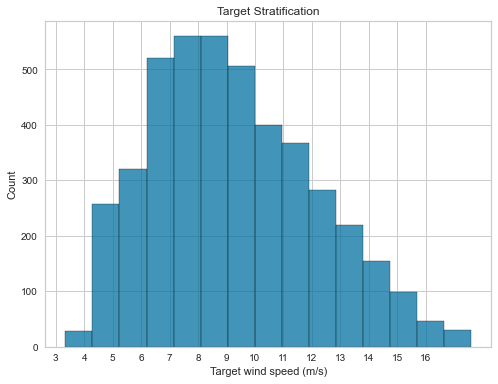

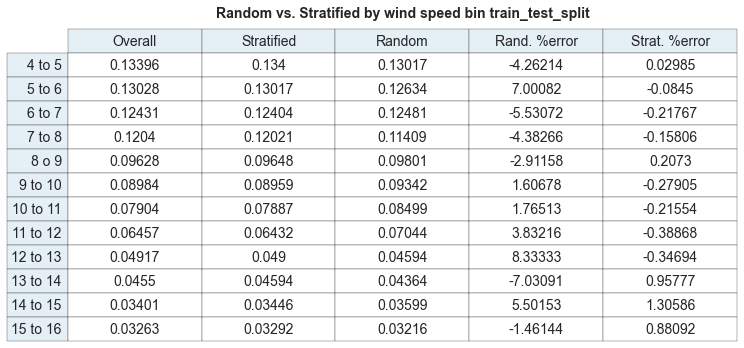

In [38]:
train_set, test_set =test_split (data_iec)

### Site Calibration importance

In [39]:
non_SC_error (test_ref1, PC)

NameError: name 'test_ref1' is not defined

### Data reference

In [40]:
#we compute the FCFs with the train set
matrix=FCF_computation(train_set)

The computed FCF_table is: 
           ratio
WD_bin          
13      1.076134
14      1.097000
15      1.089307
16      1.072202
17      1.062402
18      1.047912


In [41]:
#we apply the FCFs to the test set
test_ref=FCF_application(test_set,matrix)
train_ref=FCF_application(train_set,matrix)

In [48]:
test_ref

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WSVer,WDVer,Target,TI,WSH,WD_bin,ratio,tod,WVeer,WS_pred
708,13.365888,69.05579,13.15234,68.65078,932.061748,1.133630,942.42908,1.133615,0.0,8.672819,...,0.166000,1.205706,8.598466,0.151975,0.166613,17,0.991427,2.000000,5.217500,9.214024
1499,7.127908,81.97398,6.75578,84.18294,946.331016,1.177271,956.84960,1.176291,0.0,9.874815,...,0.180833,1.074791,10.374729,0.082447,0.162362,17,1.050625,5.333333,-7.483400,10.491027
3664,19.909950,64.94194,19.38362,67.07216,946.308968,1.126450,956.43272,1.125040,0.0,10.116624,...,0.159833,1.342671,11.848991,0.171103,0.146565,17,1.171240,20.500000,-7.020500,10.747926
734,8.391520,88.12342,7.59934,90.31796,935.598788,1.160425,945.75560,1.157492,0.0,6.626860,...,-0.074167,-0.723700,7.001905,0.160364,0.079657,18,1.056595,9.000000,0.575542,6.944368
550,14.776486,45.95841,14.38550,46.71658,945.736916,1.145328,956.06060,1.144437,0.0,9.730511,...,-0.071333,-0.185700,10.730302,0.101819,0.207261,16,1.102748,19.333333,-5.617900,10.433077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,11.799344,70.55936,11.24392,72.85612,948.789680,1.161712,959.29844,1.160179,0.0,11.009836,...,0.069750,0.383857,11.605844,0.080040,0.133039,17,1.054134,19.833333,-8.937200,11.696876
423,14.607870,71.82963,13.84714,74.72664,938.849724,1.139119,949.32416,1.137032,0.0,12.268453,...,-0.252167,-0.923700,12.922752,0.134631,0.168757,16,1.053332,18.666667,-8.291800,13.154265
3939,30.398288,21.96630,28.28692,24.95118,946.032432,1.092874,955.50848,1.085517,0.0,5.515392,...,0.123833,1.214880,4.729400,0.202782,0.046676,17,0.857491,13.000000,-8.822500,5.859565
3426,11.920556,98.19381,11.65628,99.77832,946.185780,1.156847,956.39816,1.156185,0.0,7.357052,...,0.054667,0.510480,7.446411,0.084176,0.292181,16,1.012146,2.500000,4.194800,7.888249


In [44]:
WS_pred=pd.DataFrame(test_ref['WS_pred'])

In [45]:
WS_pred

,WS_pred
708,9.214024
1499,10.491027
3664,10.747926
734,6.944368
550,10.433077
...,...
3768,11.696876
423,13.154265
3939,5.859565
3426,7.888249


In [46]:
WS_pred=pd.DataFrame(test_ref['WS_pred'])
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','IEC_WTG14.csv')

file IEC_WTG14.csv saved in \Results_ folder


FCF plot performed


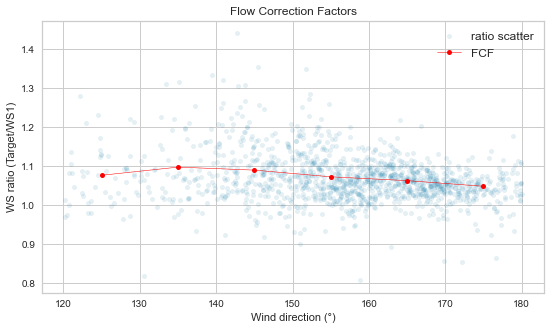

In [34]:
table= plot_FCF (test_set, matrix, 'WD_0in10')

In [49]:
AD1=test_ref['AD1']
AD1=pd.DataFrame(AD1)
save(AD1,'\Results_','AD1_WTG14.csv')

file AD1_WTG14.csv saved in \Results_ folder


In [35]:
#we also compute the corresponding power
PC= uploading_csv('\Dataset1-Normal_Site','\PC_1.15kgm-3.csv')
test_ref1=powercurve_computation(test_ref, PC)
train_ref1=powercurve_computation(train_ref, PC)

power curve computation performed
power curve computation performed


In [36]:
PC.head()

,Wind Speed [m/s],Wind Speed Distribution [Hr/Year],Warranted Power Curve [kW]
0,0.0,1.4,0
1,0.5,29.8,0
2,1.0,72.8,0
3,1.5,122.0,0
4,2.0,174.3,0


Error plot performed


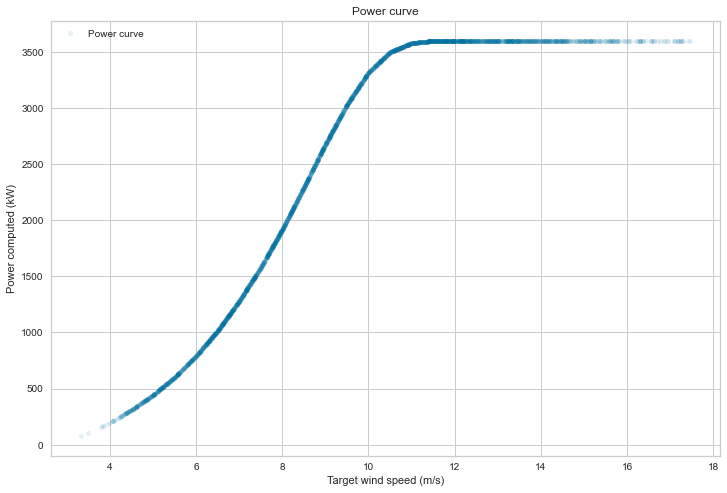

In [37]:
power_plot(train_ref1, 'Power curve')

Errors for test set
IEC method errors:
Wind RMSE:  0.467 m/s as root mean
Wind MAE:  0.349 m/s in avg
Wind MAPE:  4.051 %
Power RMSE:  214.078 kW as root mean
Power MAE:  134.039 kW in avg
Power MAPE:  8.984 %

The computed AEP_table is: 
      WPC (kW)  MPC_SC (kW)  WSAD (h/year)  WAEP (MWh)  MAEP_SC (MWh)
WS                                                                   
4.5      309.0        351.0          411.3     127.092        144.365
5.0      441.0        493.0          442.6     195.187        218.378
5.5      599.0        610.0          466.1     279.194        284.245
6.0      790.0        854.0          481.1     380.069        411.020
6.5     1014.0       1033.0          487.5     494.325        503.651
7.0     1278.0       1299.0          485.6     620.597        630.939
7.5     1578.0       1583.0          475.8     750.812        753.014
8.0     1916.0       1853.0          459.0     879.444        850.643
8.5     2290.0       2249.0          436.0     998.440       

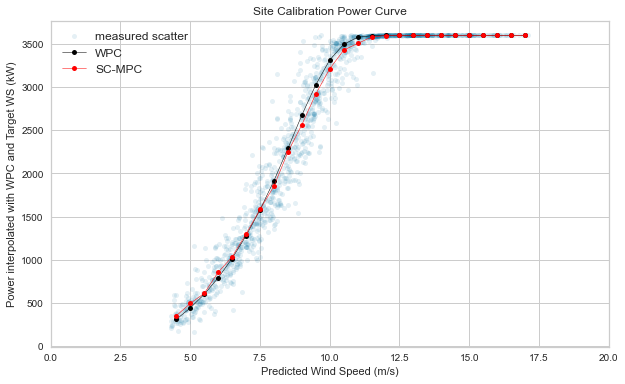

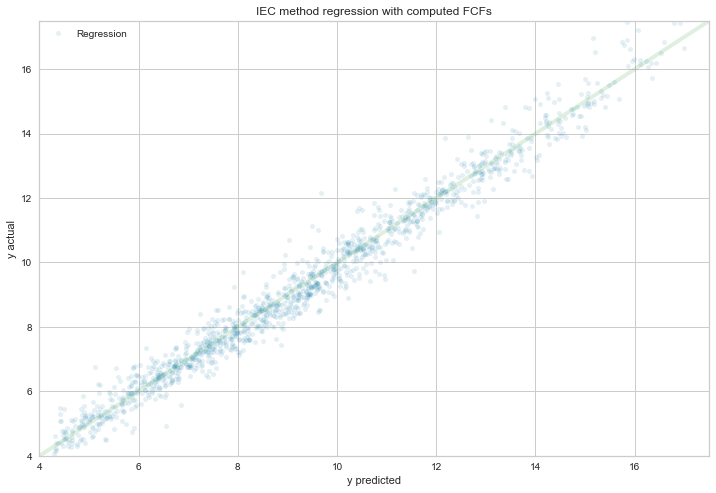

In [38]:
print('Errors for test set')
PC= uploading_csv('\Dataset1-Normal_Site','\PC_1.15kgm-3.csv')
test_ref1, AEP_table=apply_reference(test_ref1, PC)

### Data preparation 

In [61]:
del data, data_ref14
train_set.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'Target', 'TI', 'WSH', 'WD_bin', 'ratio', 'tod', 'WVeer'],
      dtype='object')

In [63]:
#drop some other columns
train_set=train_set.drop(columns=['ratio'])
test_set=test_set.drop(columns=['ratio'])

In [64]:
#data x,y

X_train,y_train=get_xy(train_set)
X_test,y_test=get_xy(test_set)


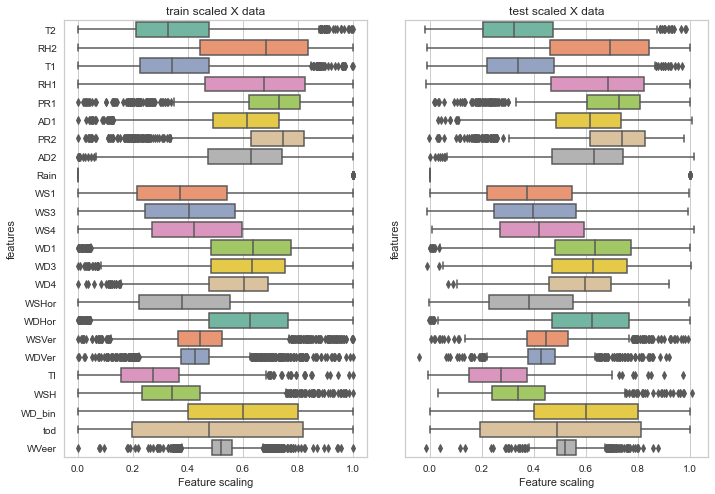

In [65]:
#feature scaling

X_train, X_test=data_scaling(X_train, X_test)
del test_set, train_set

<AxesSubplot:xlabel='WD_bin', ylabel='Count'>

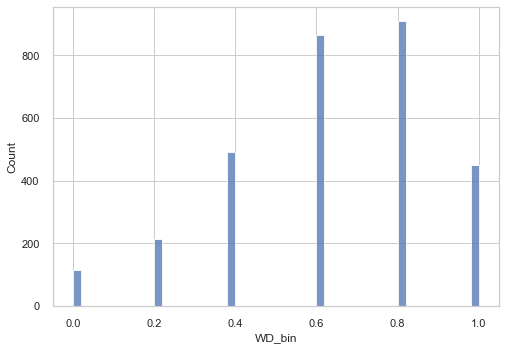

In [66]:
sns.histplot(X_train['WD_bin'], bins=50)

### Checking Linearity assumptions

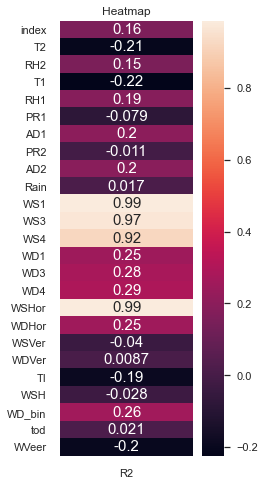

R2 table performed


In [53]:
#checking linear assumption 1- Linear relationship
R2_table (X_train,y_train)

Assumption 1- Linear relationship


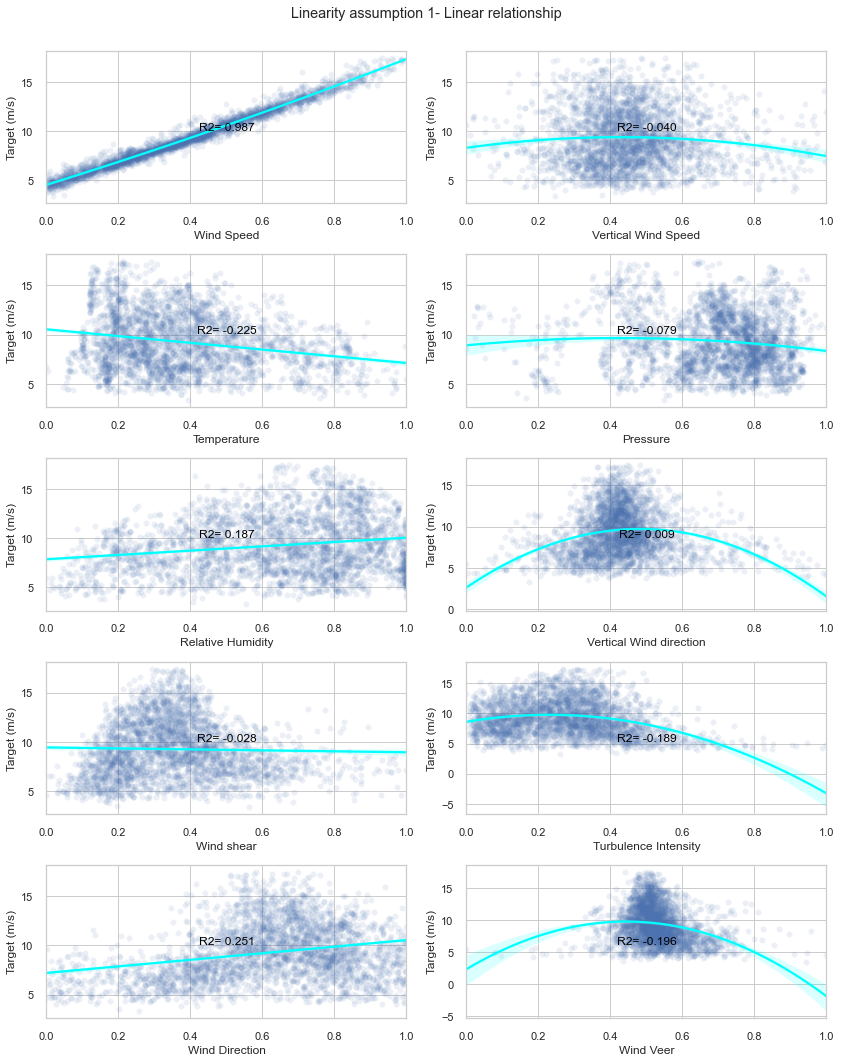

In [54]:
data_linearity1 (X_train,y_train)

Assumption 2- Multivariate normality


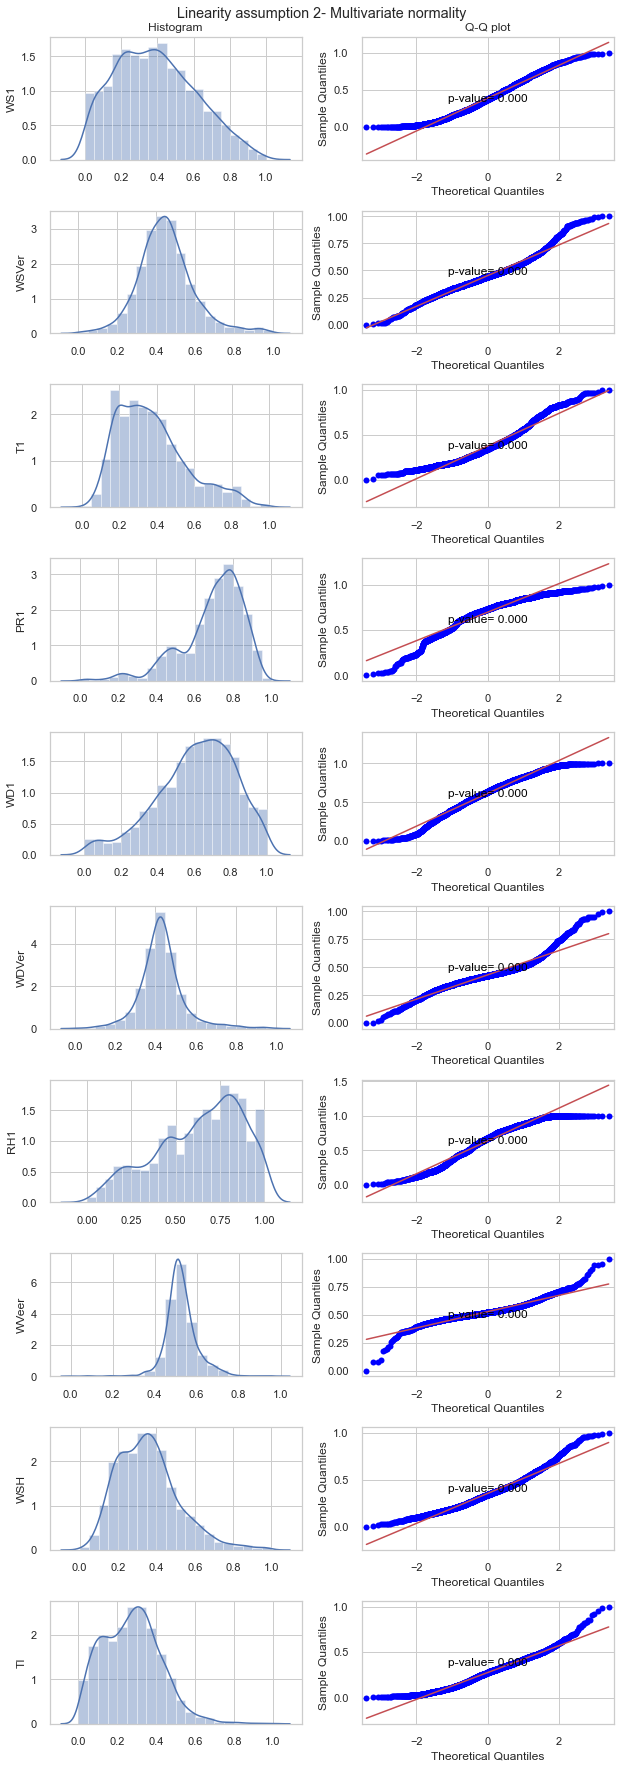

In [55]:
#Checking linear assumption 2- Multivariate normality
data_linearity2_o (X_train)

In [56]:
#Checking linear assumption 3- Little or no Multicollinearity
VIF (X_train)

Assumption 3- Little or no Multicollinearity


,feature,VIF
0,index,1.554631
1,T2,29282.136276
2,RH2,124.381886
3,T1,30730.810791
4,RH1,103.977030
5,PR1,2145.389786
6,AD1,34437.541509
7,PR2,1922.514868
8,AD2,33467.505812
9,Rain,1.098298


Assumption 3- Little or no Multicollinearity


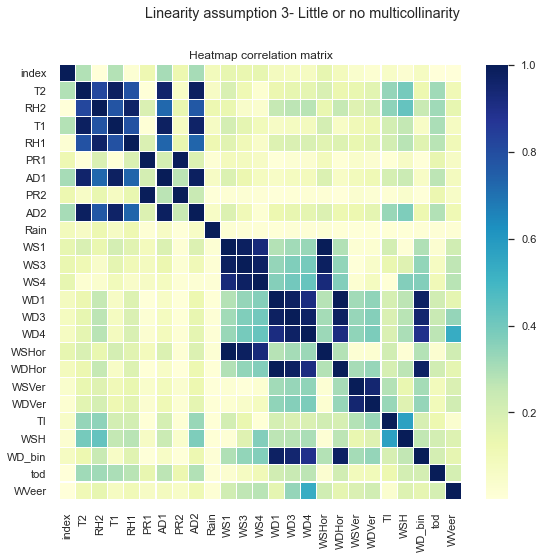

In [57]:
heatmap_corr (X_train)

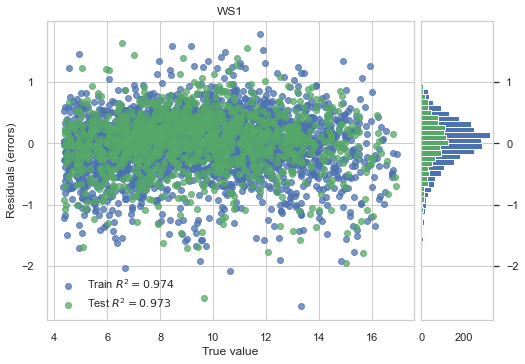

Assumption 4- Homoscedasticity


In [58]:
data_linearity4(X_train, X_test, y_train, y_test, 'WS1')

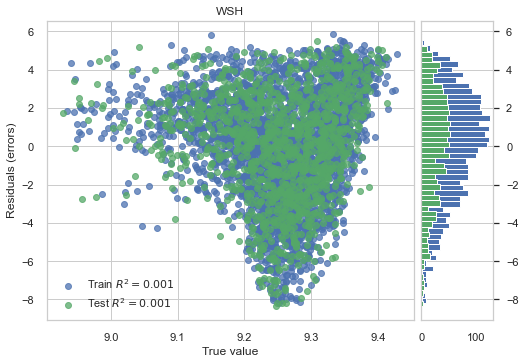

Assumption 4- Homoscedasticity


In [59]:
data_linearity4(X_train, X_test, y_train, y_test, 'WSH')

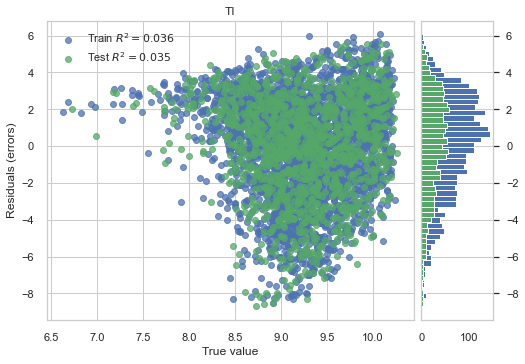

Assumption 4- Homoscedasticity


In [60]:
data_linearity4(X_train, X_test, y_train, y_test, 'TI')

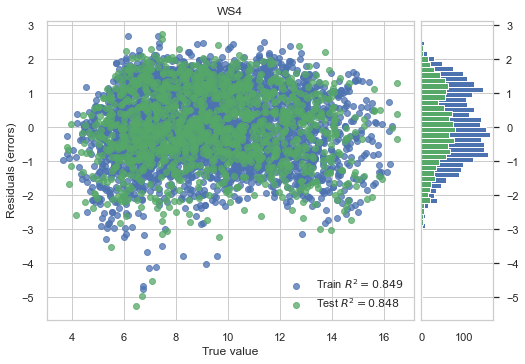

Assumption 4- Homoscedasticity


In [61]:
data_linearity4(X_train, X_test, y_train, y_test, 'WS4')

## Dataset1- WTG15

In [50]:
#upload the dataset with file_folder, file_name
data_ref15= uploading_csv('\Dataset1-Normal_Site','\data_ref15.csv')
data_ref15.keys()

Index(['time', 'HB_ref', 'T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2',
       'Rain', 'WS1', 'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor',
       'WSVer', 'WDVer', 'HB_TM', 'Target', 'TI', 'WSH', 'WD_bin', 'ratio',
       'tod', 'Daily_Cycle', 'WVeer', 'z_score'],
      dtype='object')

In [51]:
data=data_ref15.drop(columns=['time', 'HB_ref', 'Daily_Cycle', 'HB_TM', 'z_score'])
data.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'Target', 'TI', 'WSH', 'WD_bin', 'ratio', 'tod', 'WVeer'],
      dtype='object')

In [52]:
data_iec=WDbins_uncomplete(data)

Bins to drop:  [12, 11]
Data removed for IEC computation:  2.61 %


### Data split

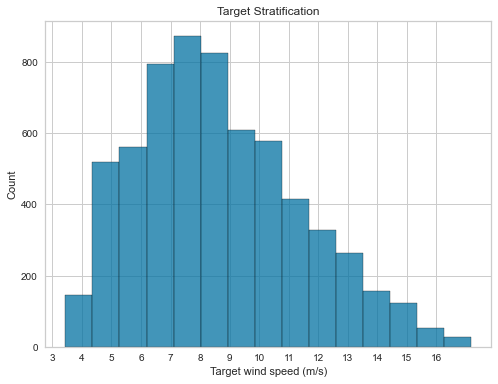

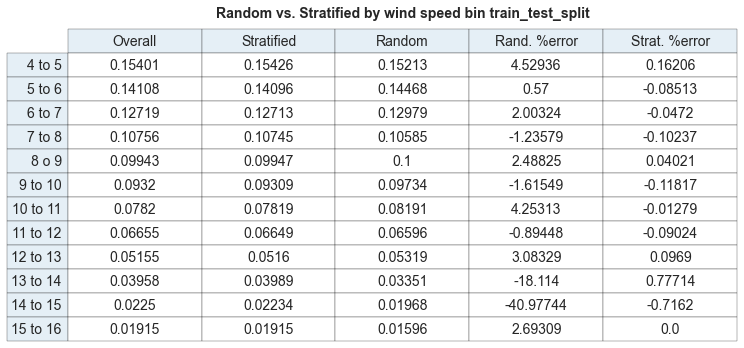

In [53]:
train_set, test_set =test_split (data_iec)

### Site Calibration importance

power curve computation performed
Wind RMSE:  0.769 m/s as root mean
Wind MAE:  0.575 m/s in avg
Wind MAPE:  6.654 %
Power RMSE:  346.72 kW as root mean
Power MAE:  225.688 kW in avg
Power MAPE:  14.643 %

The computed AEP_table is: 
      WPC (kW)  MPC_SC (kW)  WSAD (h/year)  WAEP (MWh)  MAEP_SC (MWh)
WS                                                                   
4.0      195.0        294.0          372.8      72.696        109.545
4.5      309.0        372.0          411.3     127.092        152.841
5.0      441.0        527.0          442.6     195.187        233.279
5.5      599.0        761.0          466.1     279.194        354.533
6.0      790.0        989.0          481.1     380.069        475.650
6.5     1014.0       1214.0          487.5     494.325        591.736
7.0     1278.0       1563.0          485.6     620.597        759.146
7.5     1578.0       1823.0          475.8     750.812        867.597
8.0     1916.0       2194.0          459.0     879.444       1007.

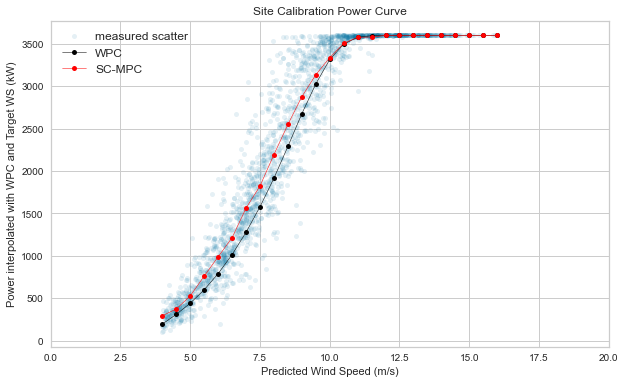

In [50]:
non_SC_error (test_ref1, PC)

### Data reference

In [54]:
#we compute the FCFs with the train set
matrix=FCF_computation(train_set)

The computed FCF_table is: 
           ratio
WD_bin          
13      1.048707
14      1.044193
15      1.055450
16      1.045861
17      1.062281
18      1.052895
19      1.048962
20      1.039654


In [55]:
#we apply the FCFs to the test set
test_ref=FCF_application(test_set,matrix)
train_ref=FCF_application(train_set,matrix)

In [56]:
WS_pred=pd.DataFrame(test_ref['WS_pred'])
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','IEC_WTG15.csv')

file IEC_WTG15.csv saved in \Results_ folder


FCF plot performed


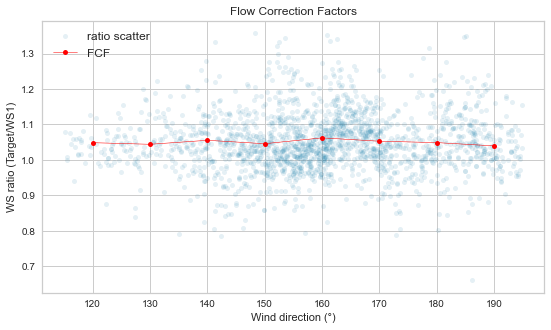

In [46]:
table= plot_FCF (test_set, matrix, 'WD_5in10')

In [47]:
#we also compute the corresponding power
PC= uploading_csv('\Dataset1-Normal_Site','\PC_1.15kgm-3.csv')
test_ref1=powercurve_computation(test_ref, PC)
train_ref1=powercurve_computation(train_ref, PC)

power curve computation performed
power curve computation performed


Error plot performed


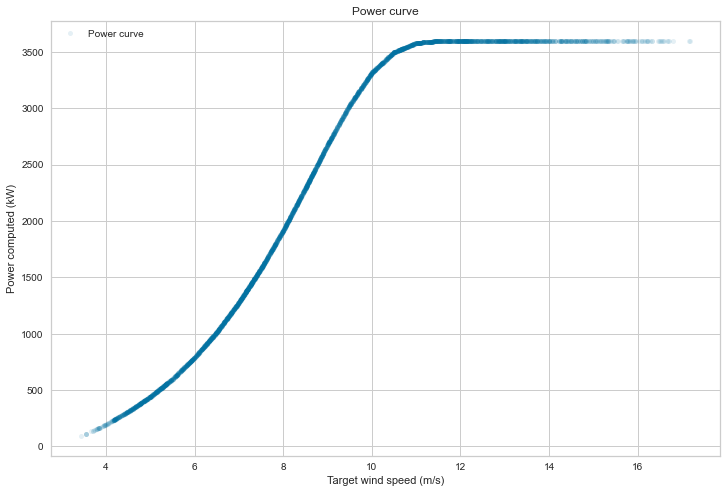

In [48]:
power_plot(train_ref1, 'Power curve')

Errors for test set
IEC method errors:
Wind RMSE:  0.655 m/s as root mean
Wind MAE:  0.49 m/s in avg
Wind MAPE:  5.877 %
Power RMSE:  305.385 kW as root mean
Power MAE:  193.655 kW in avg
Power MAPE:  14.028 %

The computed AEP_table is: 
      WPC (kW)  MPC_SC (kW)  WSAD (h/year)  WAEP (MWh)  MAEP_SC (MWh)
WS                                                                   
4.0      195.0        226.0          372.8      72.696         84.345
4.5      309.0        330.0          411.3     127.092        135.929
5.0      441.0        449.0          442.6     195.187        198.715
5.5      599.0        630.0          466.1     279.194        293.466
6.0      790.0        858.0          481.1     380.069        412.593
6.5     1014.0       1059.0          487.5     494.325        516.295
7.0     1278.0       1323.0          485.6     620.597        642.547
7.5     1578.0       1628.0          475.8     750.812        774.839
8.0     1916.0       1966.0          459.0     879.444       

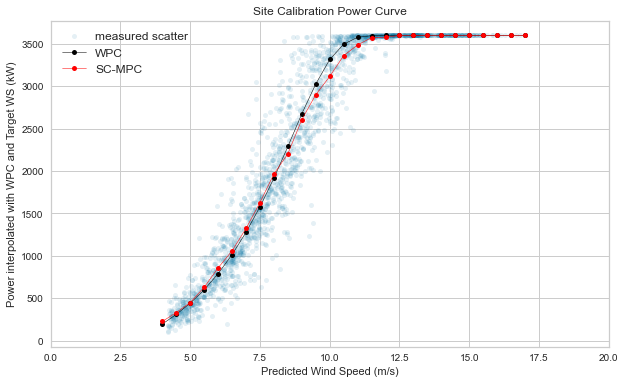

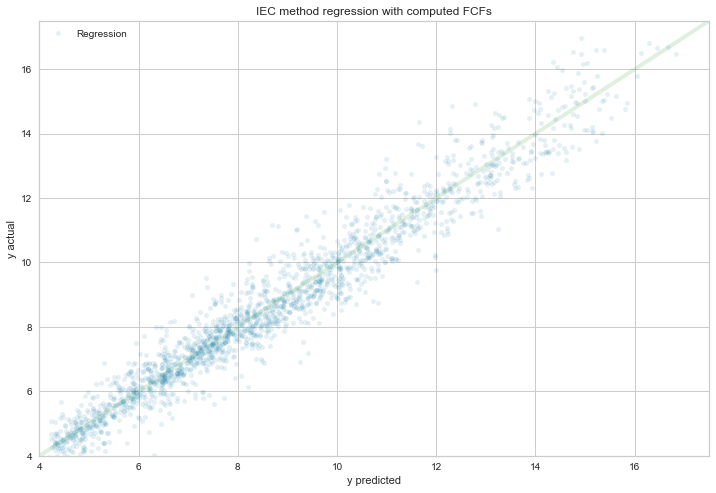

In [49]:
print('Errors for test set')
test_ref1, AEP_table=apply_reference(test_ref1, PC)

### Data preparation 

In [74]:
train_set.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'Target', 'TI', 'WSH', 'WD_bin', 'ratio', 'tod', 'WVeer'],
      dtype='object')

In [75]:
#drop some other columns
train_set=train_set.drop(columns=['ratio'])
test_set=test_set.drop(columns=['ratio'])

In [76]:
#data x,y

X_train,y_train=get_xy(train_set)
X_test,y_test=get_xy(test_set)


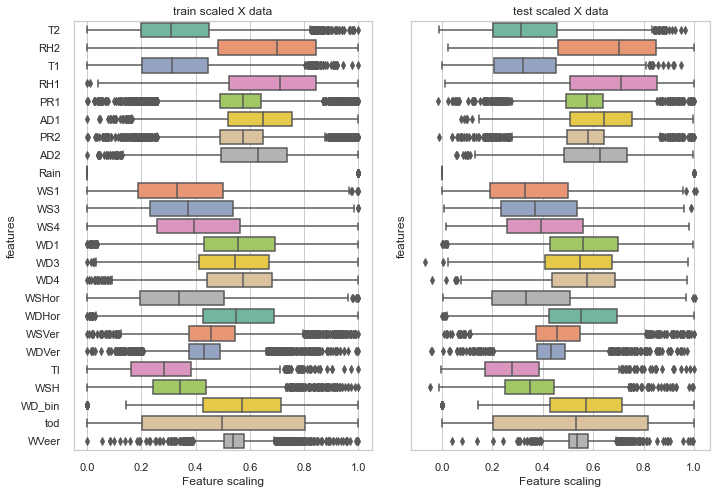

In [77]:
#feature scaling

X_train, X_test=data_scaling(X_train, X_test)
del test_set, train_set

### Checking Linearity assumptions

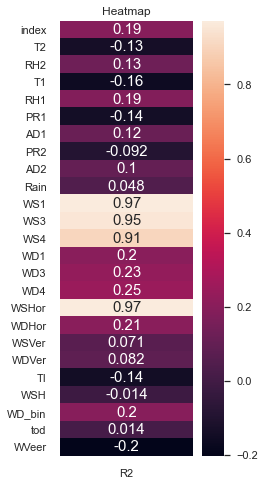

R2 table performed


In [79]:
#checking linear assumption 1- Linear relationship
R2_table (X_train,y_train)

Assumption 1- Linear relationship


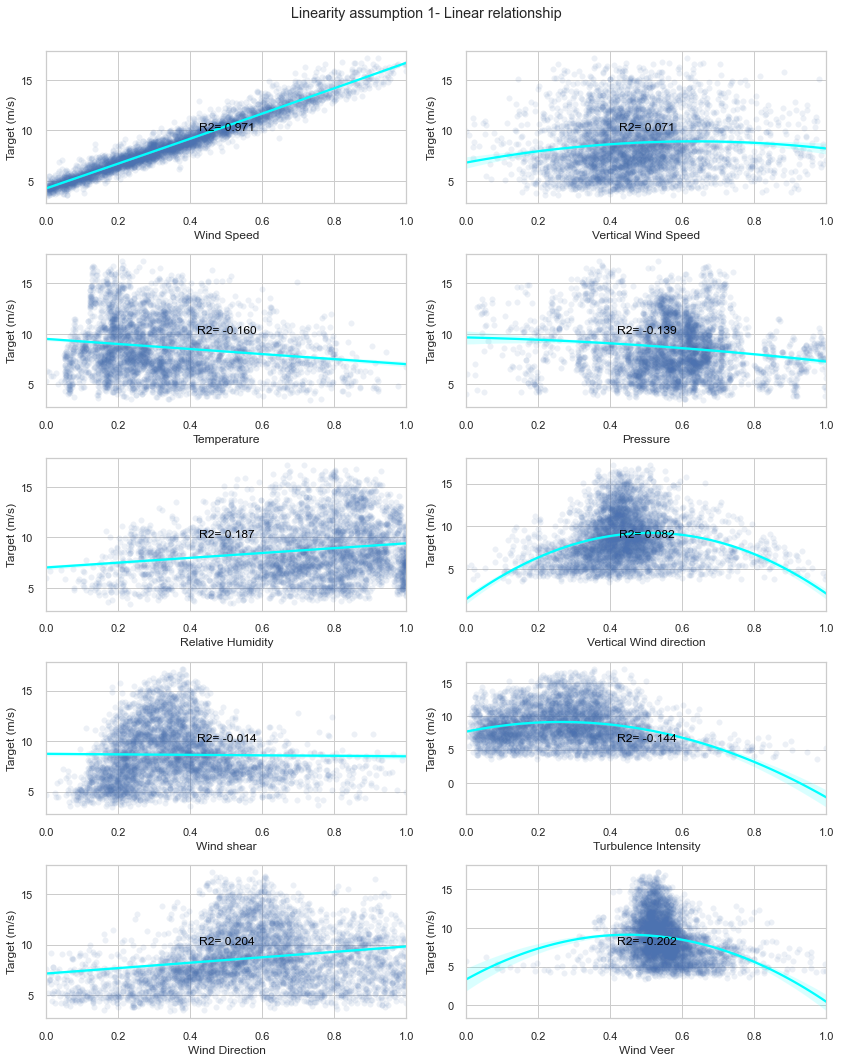

In [80]:
data_linearity1 (X_train,y_train)

Assumption 2- Multivariate normality


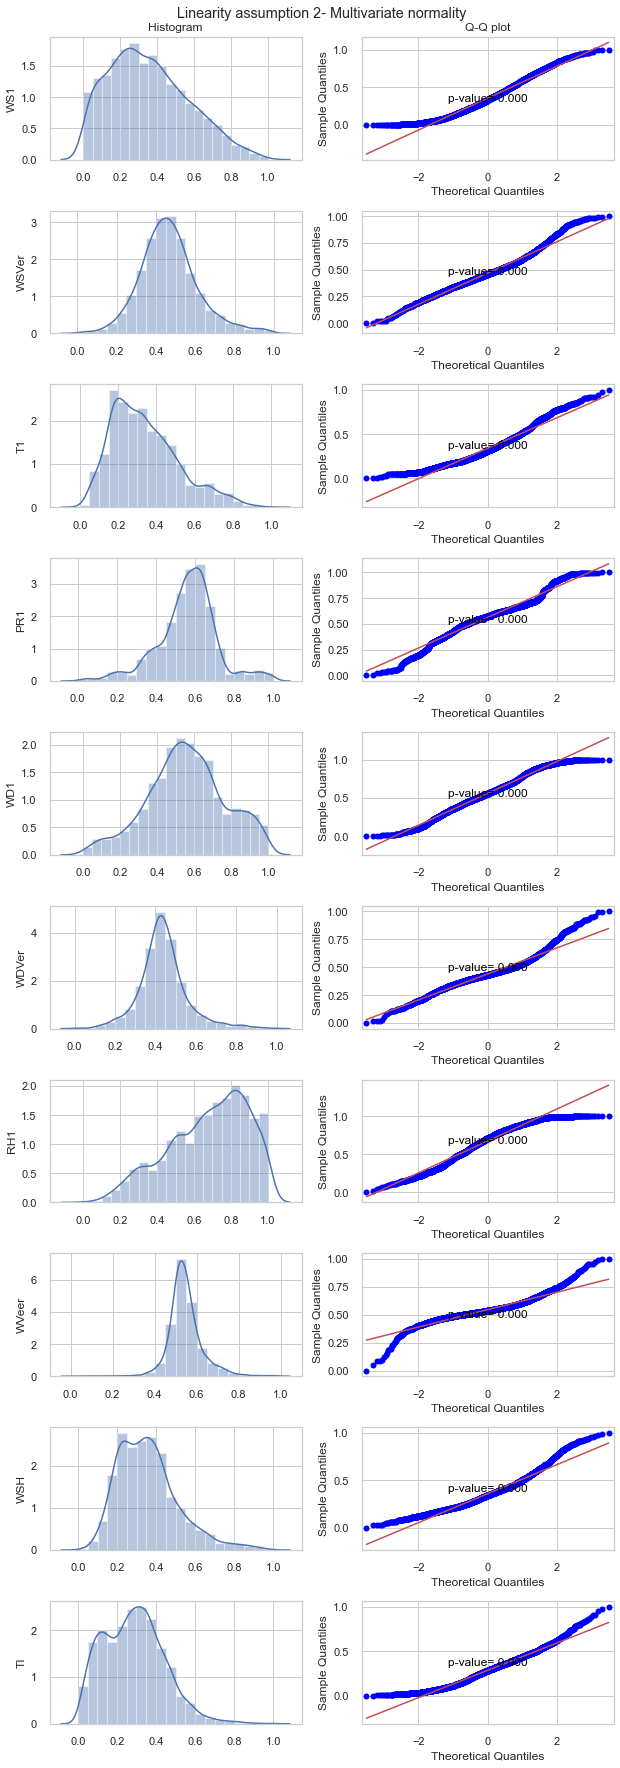

In [81]:
#Checking linear assumption 2- Multivariate normality
data_linearity2_o (X_train)

In [82]:
#Checking linear assumption 3- Little or no Multicollinearity
VIF (X_train)

Assumption 3- Little or no Multicollinearity


,feature,VIF
0,index,1.917954
1,T2,17794.974575
2,RH2,86.178022
3,T1,20680.604601
4,RH1,69.137333
5,PR1,1788.037074
6,AD1,24185.103822
7,PR2,1450.192056
8,AD2,21020.294847
9,Rain,1.073320


Assumption 3- Little or no Multicollinearity


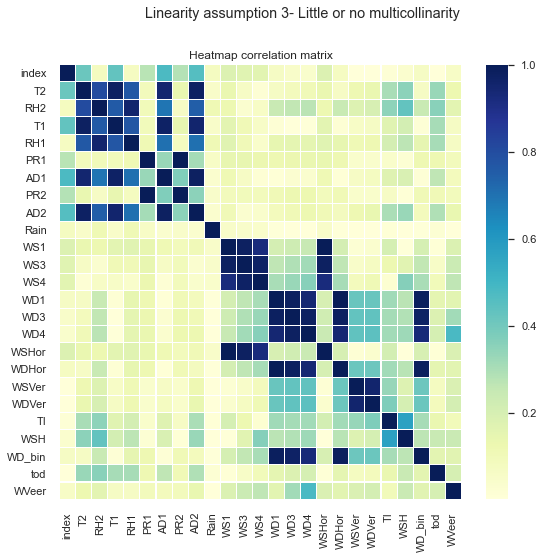

In [83]:
heatmap_corr (X_train)

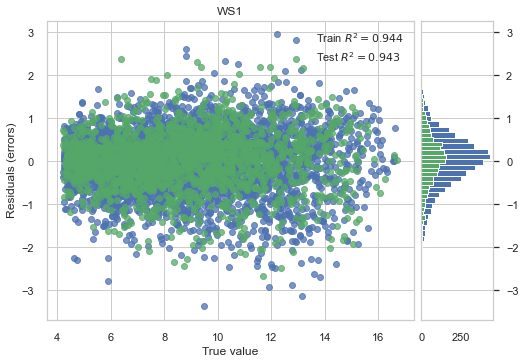

Assumption 4- Homoscedasticity


In [84]:
data_linearity4(X_train, X_test, y_train, y_test, 'WS1')

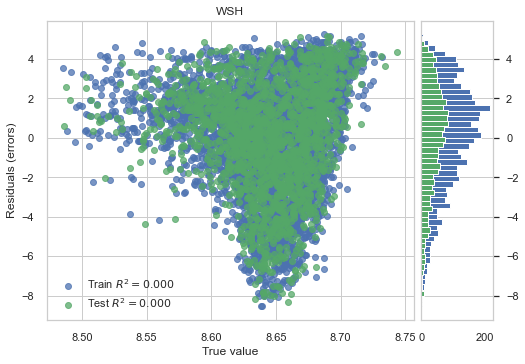

Assumption 4- Homoscedasticity


In [85]:
data_linearity4(X_train, X_test, y_train, y_test, 'WSH')

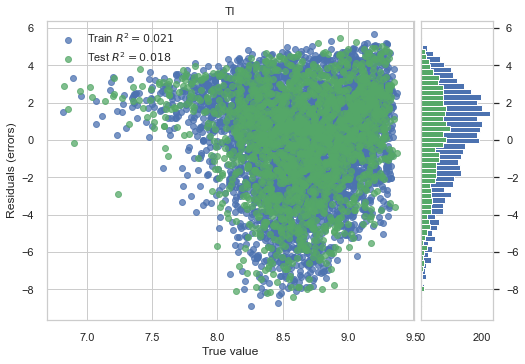

Assumption 4- Homoscedasticity


In [86]:
data_linearity4(X_train, X_test, y_train, y_test, 'TI')

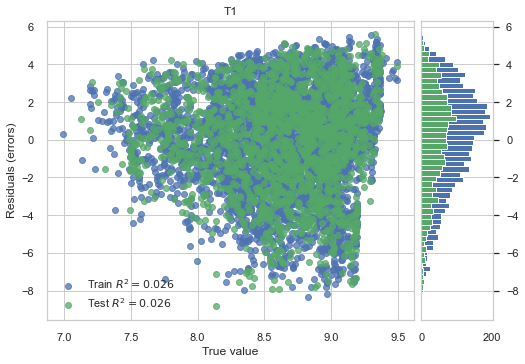

Assumption 4- Homoscedasticity


In [87]:
data_linearity4(X_train, X_test, y_train, y_test, 'T1')

## Data saving

In [67]:
save(X_train,'\Dataset1-Normal_Site','\X_train14.csv')
save(X_test,'\Dataset1-Normal_Site','\X_test14.csv')
save(y_train,'\Dataset1-Normal_Site','\y_train14.csv')
save(y_test,'\Dataset1-Normal_Site','\y_test14.csv')

file \X_train14.csv saved in \Dataset1-Normal_Site folder
file \X_test14.csv saved in \Dataset1-Normal_Site folder
file \y_train14.csv saved in \Dataset1-Normal_Site folder
file \y_test14.csv saved in \Dataset1-Normal_Site folder


In [79]:
save(X_train,'\Dataset1-Normal_Site','\X_train15.csv')
save(X_test,'\Dataset1-Normal_Site','\X_test15.csv')
save(y_train,'\Dataset1-Normal_Site','\y_train15.csv')
save(y_test,'\Dataset1-Normal_Site','\y_test15.csv')

file \X_train15.csv saved in \Dataset1-Normal_Site folder
file \X_test15.csv saved in \Dataset1-Normal_Site folder
file \y_train15.csv saved in \Dataset1-Normal_Site folder
file \y_test15.csv saved in \Dataset1-Normal_Site folder


## Uploading back data

In [ ]:
data_comp15= uploading_csv('\Dataset1-Normal_Site','\data_comp_15.csv')
data_ref15= uploading_csv('\Dataset1-Normal_Site','\data_ref_15.csv

# Copy-paste cells

In [ ]:
import nbformat as nbf
from glob import glob

import uuid
def get_cell_id(id_length=8):
    return uuid.uuid4().hex[:id_length]

# your notebook name/keyword
nb_name = 'Dataset1- Preparation- V2-Copy3'
notebooks = list(filter(lambda x: nb_name in x, glob("./*.ipynb", recursive=True)))

# iterate over notebooks
for ipath in sorted(notebooks):
    # load notebook
    ntbk = nbf.read(ipath, nbf.NO_CONVERT)
    
    cell_ids = []
    for cell in ntbk.cells:
        cell_ids.append(cell['id'])

    # reset cell ids if there are duplicates
    if not len(cell_ids) == len(set(cell_ids)): 
        for cell in ntbk.cells:
            cell['id'] = get_cell_id()

    nbf.write(ntbk, ipath)